In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

In [22]:
df = pd.read_csv('breast-cancer.csv')

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
df.shape

(569, 32)

In [23]:
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np.where(y_train == 'M', 1, 0)
y_test = np.where(y_test == 'M', 1, 0)

In [25]:
class SANE:
    def __init__(self, input_shape, output_shape, population_size, mutation_rate, num_generations):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.num_generations = num_generations
        self.history = []  # Network structure for recording calendar time

    def evolve(self, X_train, y_train):
        self.population = self.create_population()
        for i in range(self.num_generations):
            self.fitness_scores = self.get_fitness_scores(X_train, y_train)
            print("Generation", i+1, "Best score:", np.max(self.fitness_scores))

            new_population = []
            for j in range(self.population_size):
                parent1, parent2 = self.select_parents()
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)

            self.population = new_population

            # Record the network structure of the current generation
            current_population = [model.get_weights() for model in self.population]
            self.history.append(current_population)

    def create_population(self):
        population = []
        for i in range(self.population_size):
            model = Sequential()
            model.add(Dense(16, input_shape=self.input_shape, activation='relu'))
            model.add(Dense(16, activation='relu'))
            model.add(Dense(self.output_shape, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.build((None, self.input_shape))
            population.append(model)
        return population

    def mutate(self, model):
        weights = model.get_weights()
        for i, w in enumerate(weights):
            if len(w.shape) == 1:  # Bias invariant
                continue
            mask = np.random.rand(*w.shape) < self.mutation_rate
            weights[i] = np.where(mask, w+np.random.normal(size=w.shape), w)
        model.set_weights(weights)
        return model

    def get_fitness_scores(self, X_train, y_train):
        scores = []
        for model in self.population:
            model.fit(X_train, y_train, epochs=1, verbose=0)
            score = model.evaluate(X_train, y_train, verbose=0)[1]
            scores.append(score)
        return scores

    def get_best_model(self, X_train, y_train):
        fitness_scores = self.get_fitness_scores(X_train, y_train)
        best_model_index = np.argmax(fitness_scores)
        return self.population[best_model_index]

    def select_parents(self):
        fitness_scores = np.array(self.fitness_scores)
        fitness_scores = fitness_scores / np.sum(fitness_scores)  # Normalization
        parent_indices = np.random.choice(range(self.population_size), size=2, replace=False, p=fitness_scores)
        parent1 = self.population[parent_indices[0]]
        parent2 = self.population[parent_indices[1]]
        return parent1, parent2

    def crossover(self, parent1, parent2):
        child = Sequential()
        child.add(Dense(16, input_shape=self.input_shape, activation='relu'))
        child.add(Dense(16, activation='relu'))
        child.add(Dense(self.output_shape, activation='sigmoid'))

        weights1 = parent1.get_weights()
        weights2 = parent2.get_weights()

        new_weights1, new_weights2 = self.adjust_weights_shape(weights1, weights2)

        child_weights = []
        for w1, w2 in zip(new_weights1, new_weights2):
            mask = np.random.choice([0, 1], size=w1.shape)  # Randomly select the corresponding weights of the parent
            child_weights.append(np.where(mask, w1, w2))

        child.set_weights(child_weights)
        child.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        child.build((None, self.input_shape))
        return child  #Used to perform crossover operations to generate new offspring individuals.

    def adjust_weights_shape(self, weights1, weights2):
        """
        Adjusts the shape of the weight arrays to ensure they have the same dimensions
        Used to adjust the shape of the weight array to ensure that both weight arrays have the same dimensionality.
        """
        new_weights1, new_weights2 = [], []
        for w1, w2 in zip(weights1, weights2):
            if w1.shape != w2.shape:
                # adjust the shape of w1
                tmp_w1 = np.zeros(w2.shape)
                tmp_w1[:w1.shape[0], :w1.shape[1]] = w1
                new_weights1.append(tmp_w1)

                # adjust the shape of w2
                tmp_w2 = np.zeros(w1.shape)
                tmp_w2[:w2.shape[0], :w2.shape[1]] = w2
                new_weights2.append(tmp_w2)
            else:
                new_weights1.append(w1)
                new_weights2.append(w2)

        return new_weights1, new_weights2


In [26]:
# Define the parameters of SANE algorithm
input_shape = (X_train.shape[1],)
output_shape = 1
population_size = 10 #Population size
mutation_rate = 0.35  #Variation rate
num_generations = 100

# Training neural networks using SANE algorithm
sane = SANE(input_shape, output_shape, population_size, mutation_rate, num_generations)
sane.evolve(X_train, y_train)
best_model = sane.get_best_model(X_train, y_train)

Generation 1 Best score: 0.6361502408981323
Generation 2 Best score: 0.6314554214477539
Generation 3 Best score: 0.6314554214477539
Generation 4 Best score: 0.6455398797988892
Generation 5 Best score: 0.6314554214477539
Generation 6 Best score: 0.6314554214477539
Generation 7 Best score: 0.6314554214477539
Generation 8 Best score: 0.6314554214477539
Generation 9 Best score: 0.6314554214477539
Generation 10 Best score: 0.6314554214477539
Generation 11 Best score: 0.6314554214477539
Generation 12 Best score: 0.6314554214477539
Generation 13 Best score: 0.6314554214477539
Generation 14 Best score: 0.6314554214477539
Generation 15 Best score: 0.6314554214477539
Generation 16 Best score: 0.6314554214477539
Generation 17 Best score: 0.6314554214477539
Generation 18 Best score: 0.6314554214477539
Generation 19 Best score: 0.6314554214477539
Generation 20 Best score: 0.6314554214477539
Generation 21 Best score: 0.6314554214477539
Generation 22 Best score: 0.6314554214477539
Generation 23 Best 

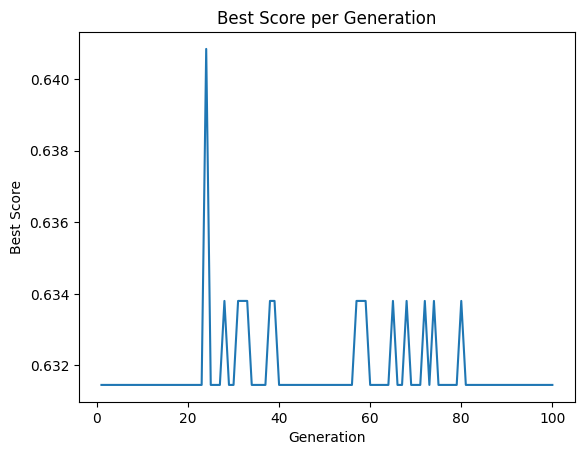

In [27]:
# Get the best scores for each generation
best_scores = []
for generation in sane.history:
    generation_scores = []
    for weights in generation:
        model = sane.create_population()[0]  # Rebuild the model
        model.set_weights(weights)  # Set the weights
        _, accuracy = model.evaluate(X_train, y_train, verbose=0)
        generation_scores.append(accuracy)
    best_scores.append(np.max(generation_scores))

# Plot the generation vs. best score
plt.plot(range(1, num_generations + 1), best_scores)
plt.xlabel('Generation')
plt.ylabel('Best Score')
plt.title('Best Score per Generation')
plt.show()


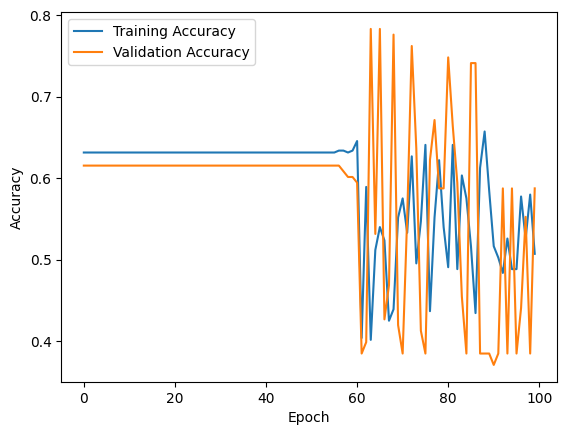

In [28]:
# Test the best model and plot convergence
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Calculate the accuracy of the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', score[1])

Test Accuracy: 0.5874125957489014


# mutation_rate = 0.4  
# num_generations = 150


In [30]:
# Define the parameters of SANE algorithm
input_shape = (X_train.shape[1],)
output_shape = 1
population_size = 10 #Population size
mutation_rate = 0.4  #Variation rate
num_generations = 150

# Training neural networks using SANE algorithm
sane = SANE(input_shape, output_shape, population_size, mutation_rate, num_generations)
sane.evolve(X_train, y_train)
best_model = sane.get_best_model(X_train, y_train)

Generation 1 Best score: 0.6807511448860168
Generation 2 Best score: 0.6314554214477539
Generation 3 Best score: 0.6314554214477539
Generation 4 Best score: 0.6338028311729431
Generation 5 Best score: 0.6525821685791016
Generation 6 Best score: 0.6314554214477539
Generation 7 Best score: 0.6338028311729431
Generation 8 Best score: 0.6314554214477539
Generation 9 Best score: 0.6314554214477539
Generation 10 Best score: 0.6314554214477539
Generation 11 Best score: 0.6314554214477539
Generation 12 Best score: 0.6314554214477539
Generation 13 Best score: 0.6314554214477539
Generation 14 Best score: 0.6338028311729431
Generation 15 Best score: 0.6314554214477539
Generation 16 Best score: 0.6314554214477539
Generation 17 Best score: 0.6314554214477539
Generation 18 Best score: 0.6314554214477539
Generation 19 Best score: 0.6338028311729431
Generation 20 Best score: 0.6314554214477539
Generation 21 Best score: 0.6361502408981323
Generation 22 Best score: 0.6314554214477539
Generation 23 Best 

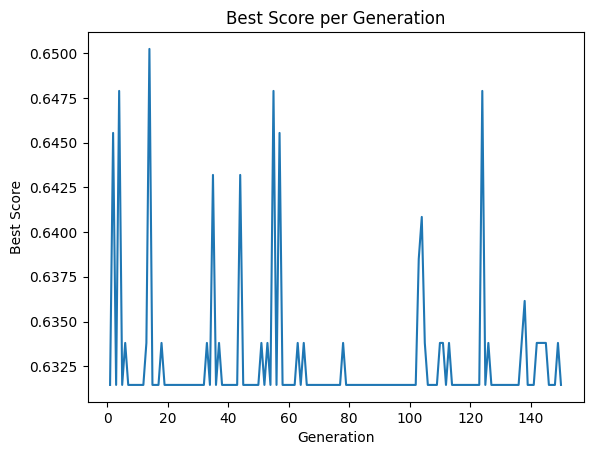

In [31]:
# Get the best scores for each generation
best_scores = []
for generation in sane.history:
    generation_scores = []
    for weights in generation:
        model = sane.create_population()[0]  # Rebuild the model
        model.set_weights(weights)  # Set the weights
        _, accuracy = model.evaluate(X_train, y_train, verbose=0)
        generation_scores.append(accuracy)
    best_scores.append(np.max(generation_scores))

# Plot the generation vs. best score
plt.plot(range(1, num_generations + 1), best_scores)
plt.xlabel('Generation')
plt.ylabel('Best Score')
plt.title('Best Score per Generation')
plt.show()

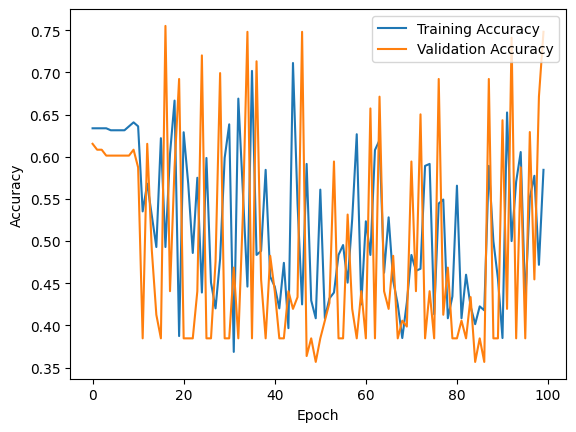

In [32]:
# Test the best model and plot convergence
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
# Calculate the accuracy of the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', score[1])

Test Accuracy: 0.748251736164093


In [ ]:
33333333333333333333

In [18]:
# Define the parameters of SANE algorithm
input_shape = (X_train.shape[1],)
output_shape = 1
population_size = 10 #Population size
mutation_rate = 0.35  #Variation rate
num_generations = 30

# Training neural networks using SANE algorithm
sane = SANE(input_shape, output_shape, population_size, mutation_rate, num_generations)
sane.evolve(X_train, y_train)
best_model = sane.get_best_model(X_train, y_train)

Generation 1 Best score: 0.6314554214477539
Generation 2 Best score: 0.6338028311729431
Generation 3 Best score: 0.6314554214477539
Generation 4 Best score: 0.6314554214477539
Generation 5 Best score: 0.3685446083545685
Generation 6 Best score: 0.6314554214477539
Generation 7 Best score: 0.6314554214477539
Generation 8 Best score: 0.6361502408981323
Generation 9 Best score: 0.6314554214477539
Generation 10 Best score: 0.6314554214477539
Generation 11 Best score: 0.6314554214477539
Generation 12 Best score: 0.6314554214477539
Generation 13 Best score: 0.6314554214477539
Generation 14 Best score: 0.6502347588539124
Generation 15 Best score: 0.6338028311729431
Generation 16 Best score: 0.6314554214477539
Generation 17 Best score: 0.6314554214477539
Generation 18 Best score: 0.6314554214477539
Generation 19 Best score: 0.6314554214477539
Generation 20 Best score: 0.6314554214477539
Generation 21 Best score: 0.6314554214477539
Generation 22 Best score: 0.6314554214477539
Generation 23 Best 

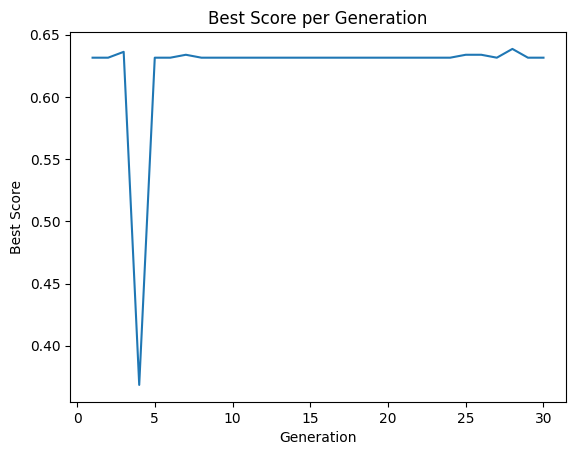

In [19]:
# Get the best scores for each generation
best_scores = []
for generation in sane.history:
    generation_scores = []
    for weights in generation:
        model = sane.create_population()[0]  # Rebuild the model
        model.set_weights(weights)  # Set the weights
        _, accuracy = model.evaluate(X_train, y_train, verbose=0)
        generation_scores.append(accuracy)
    best_scores.append(np.max(generation_scores))

# Plot the generation vs. best score
plt.plot(range(1, num_generations + 1), best_scores)
plt.xlabel('Generation')
plt.ylabel('Best Score')
plt.title('Best Score per Generation')
plt.show()

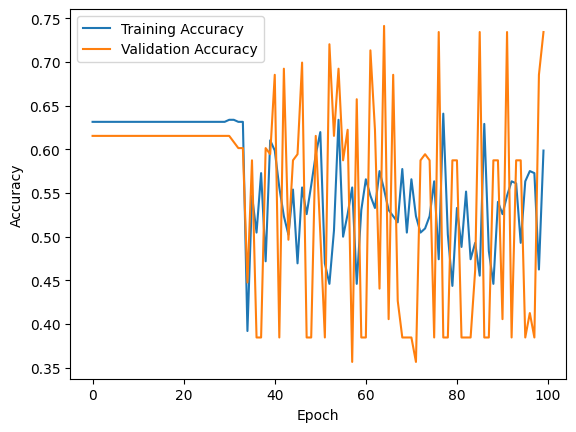

In [20]:
# Test the best model and plot convergence
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
# Calculate the accuracy of the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', score[1])

Test Accuracy: 0.7342657446861267


 create a neural network model and visualize its topology using a directed graph.

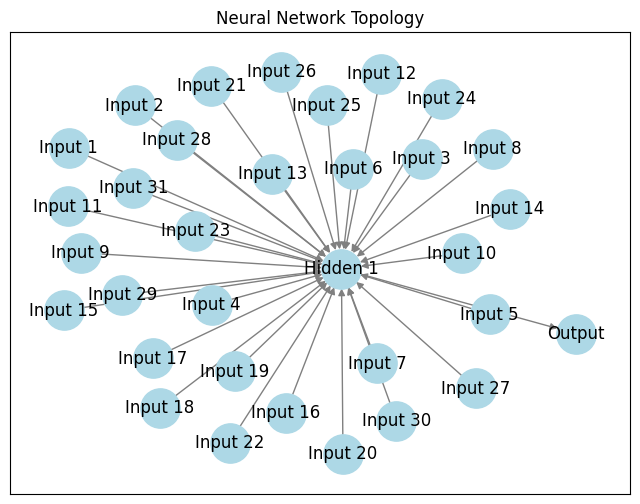

In [ ]:
# Creating Neural Network Models
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Drawing the topology of a neural network
G = nx.DiGraph()

# Adding input layer nodes
for i in range(X_train.shape[1]):
    G.add_node(f'Input {i+1}')

# Add hidden layer node
for i in range(len(model.layers)-1):
    G.add_node(f'Hidden {i+1}')

# Adding output layer nodes
G.add_node('Output')

# Add side connection
for i in range(X_train.shape[1]):
    G.add_edge(f'Input {i+1}', f'Hidden 1')

G.add_edge(f'Hidden 1', 'Output')

# Draw the topology
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_size=800, node_color='lightblue', edge_color='gray')
plt.title('Neural Network Topology')
plt.show()



# Visualize the weights of the first hidden layer

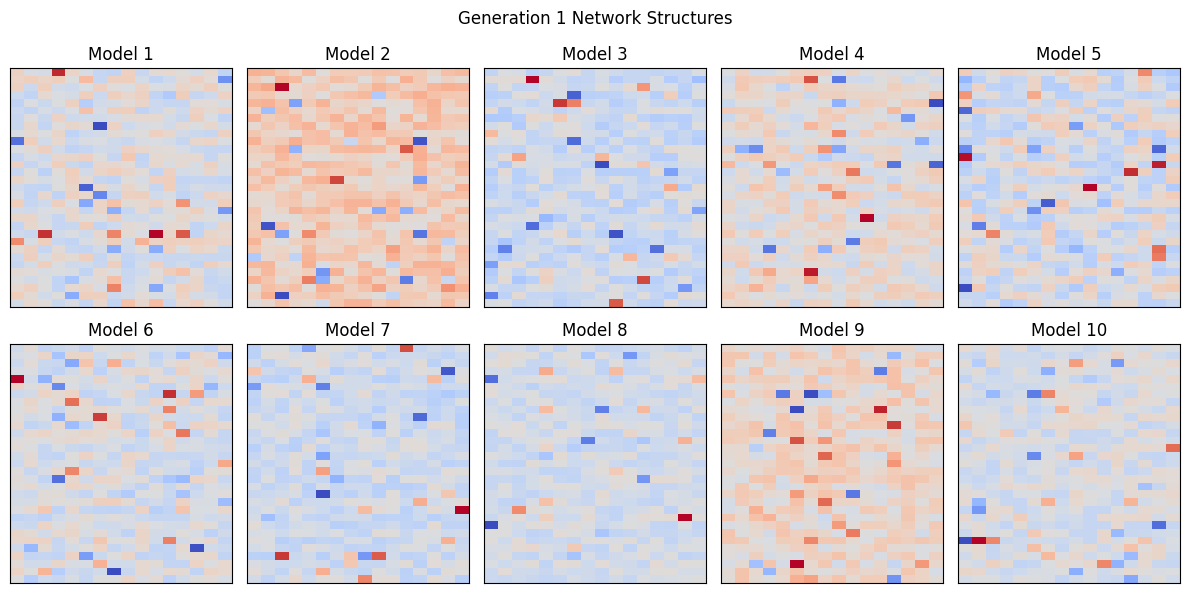

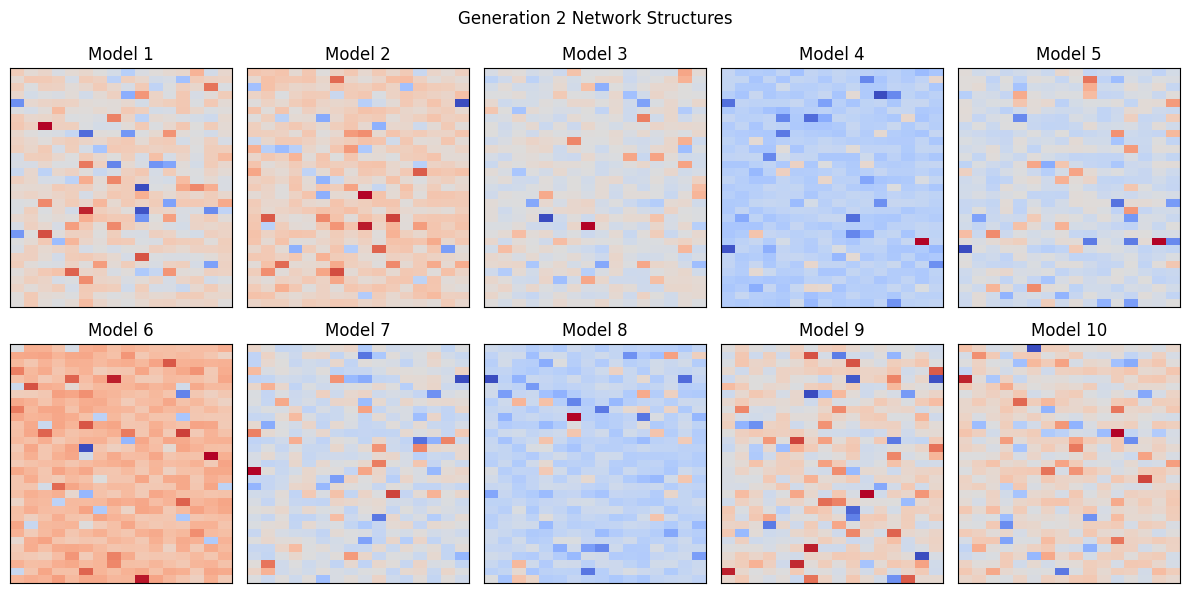

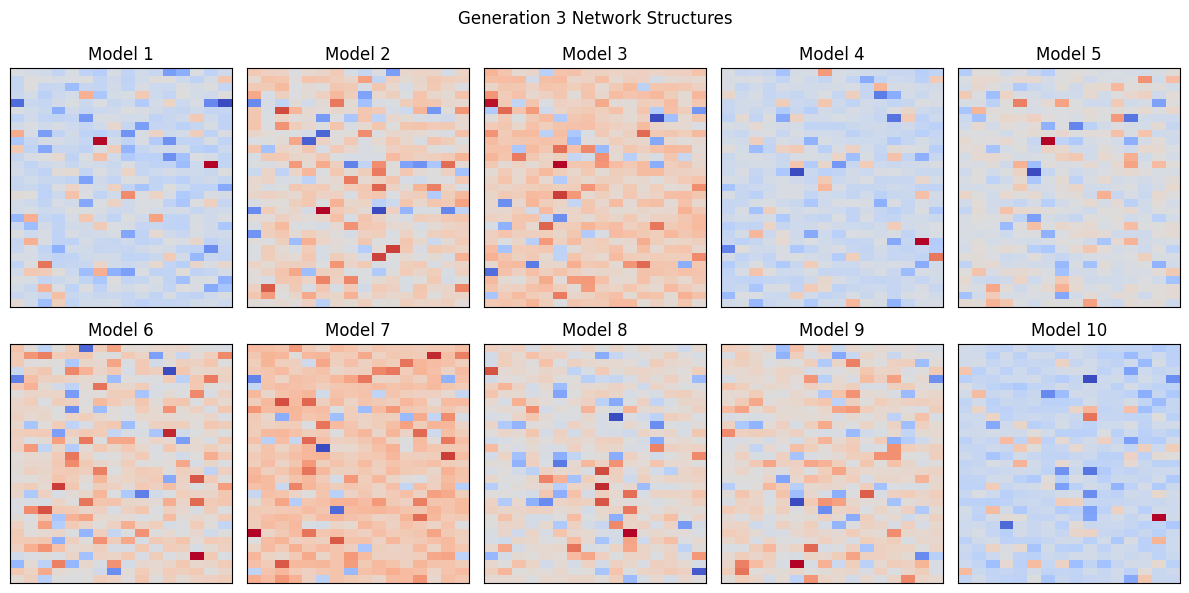

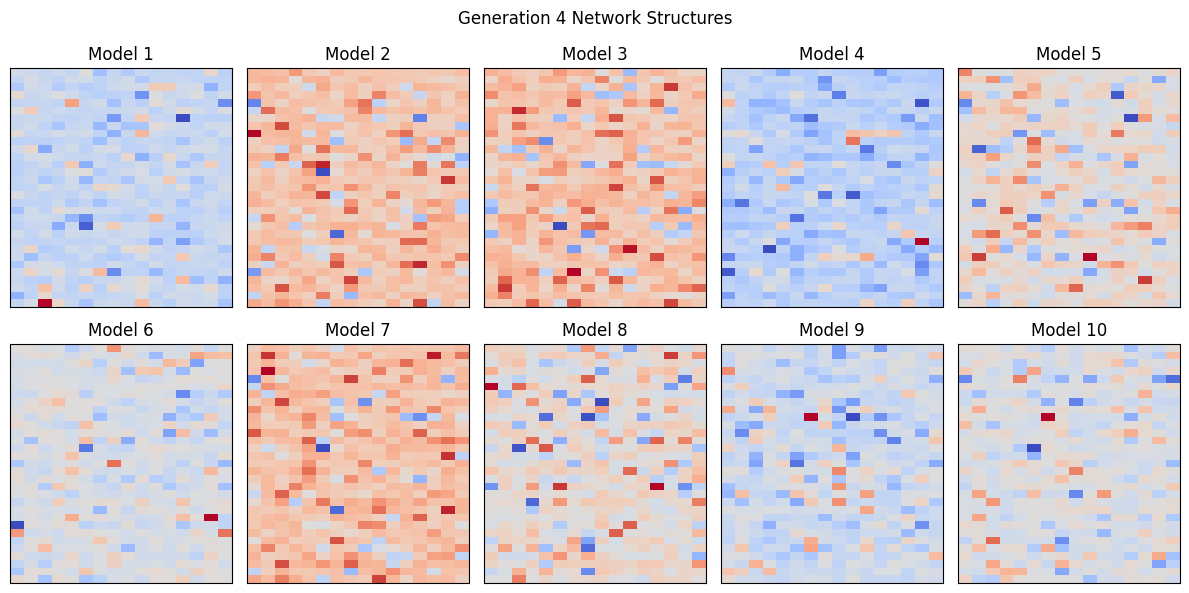

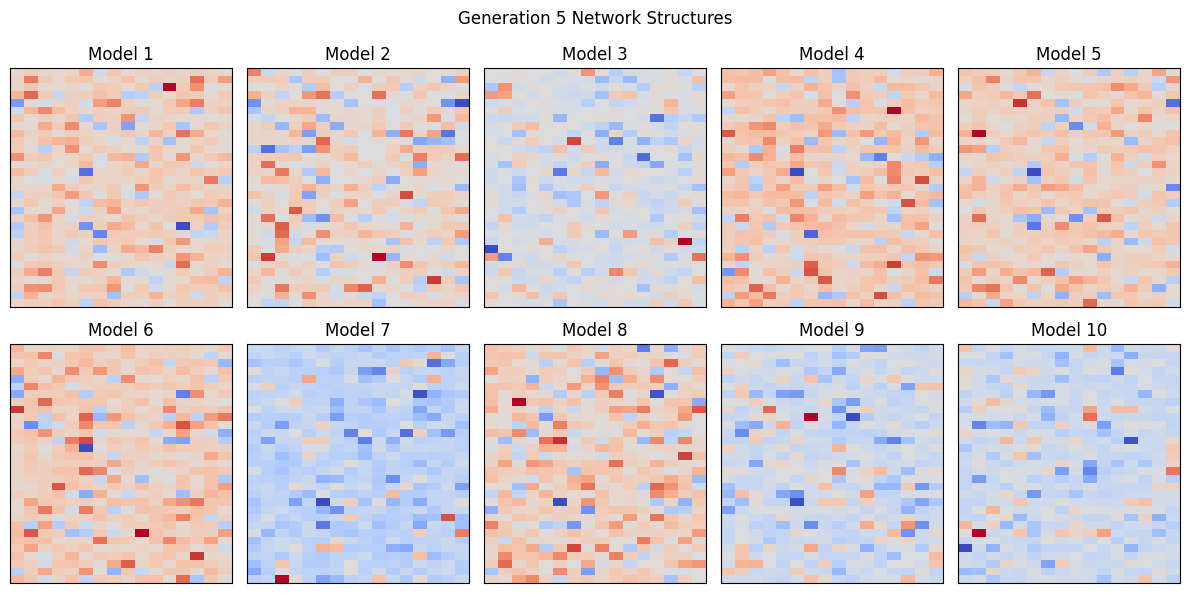

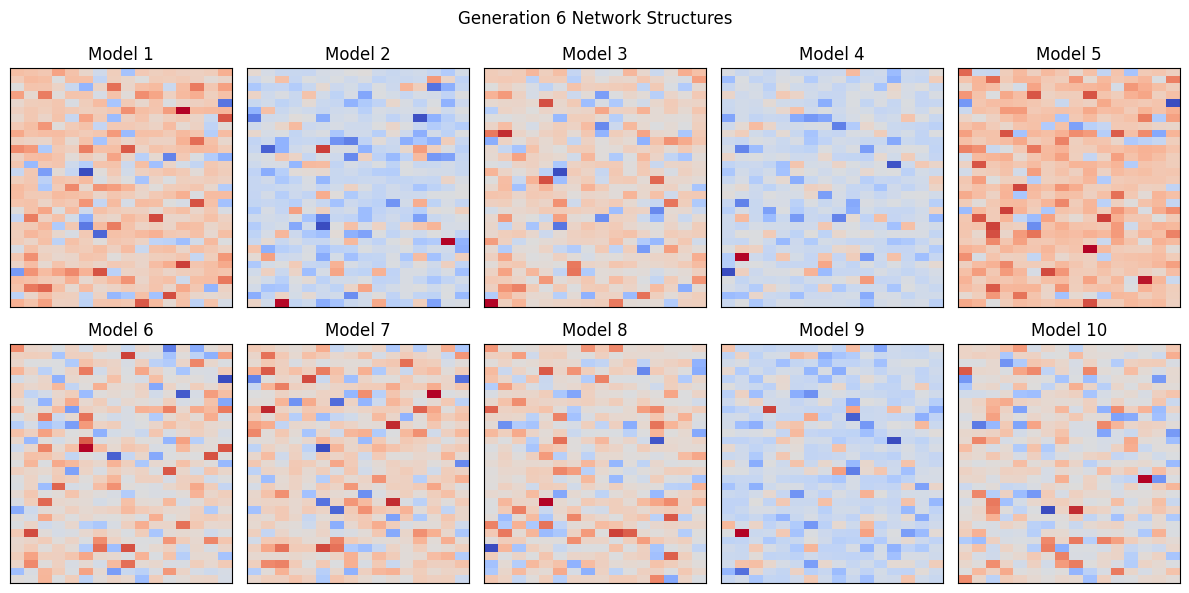

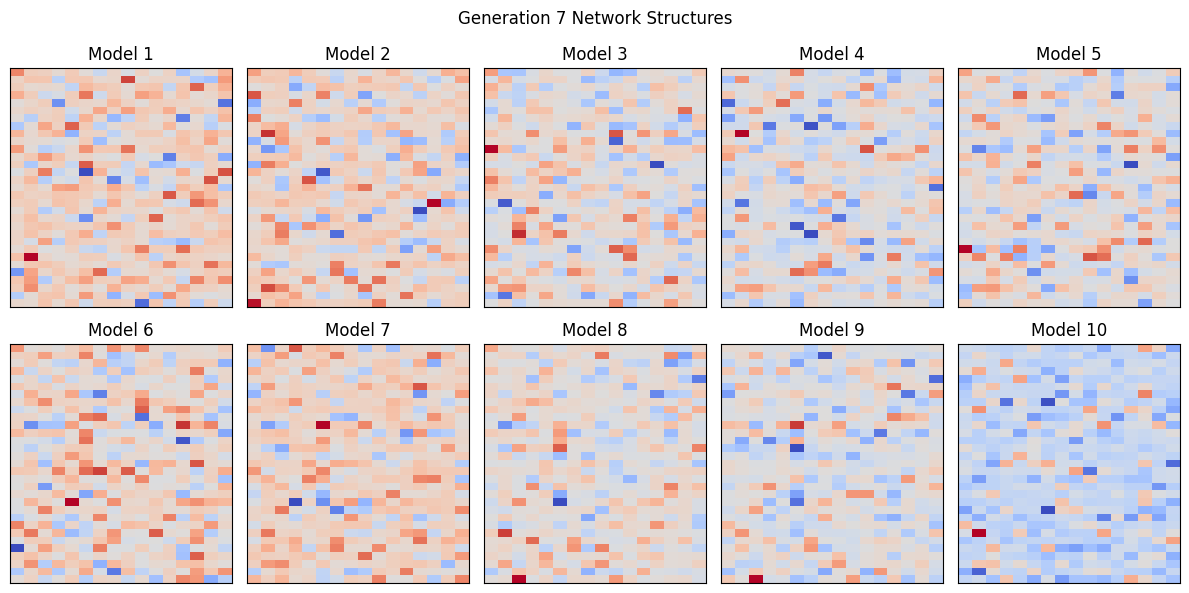

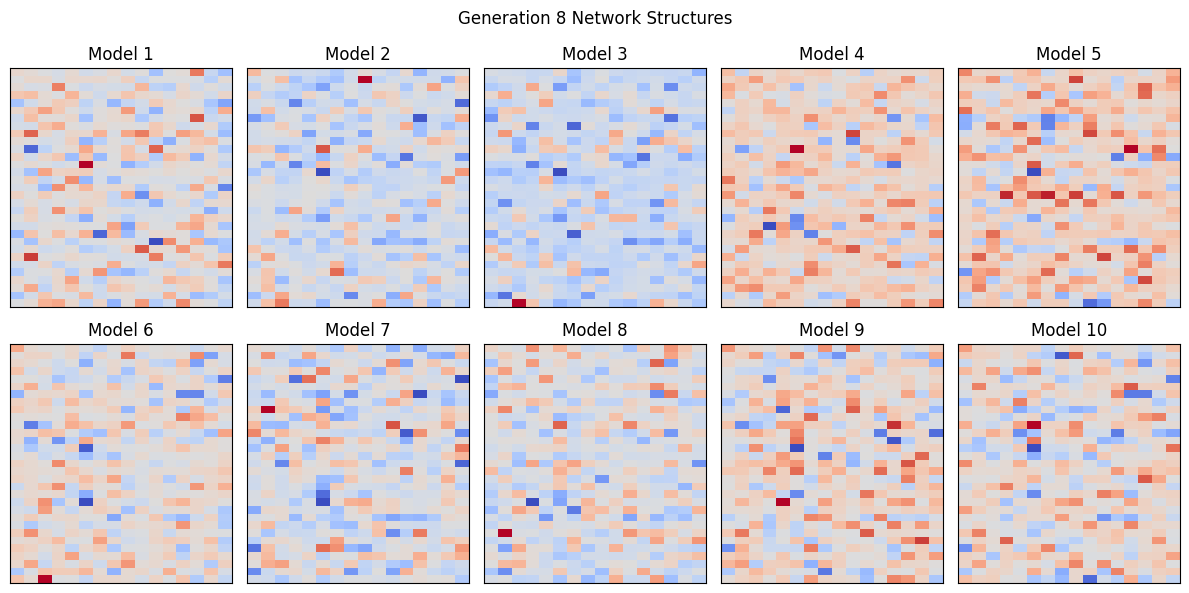

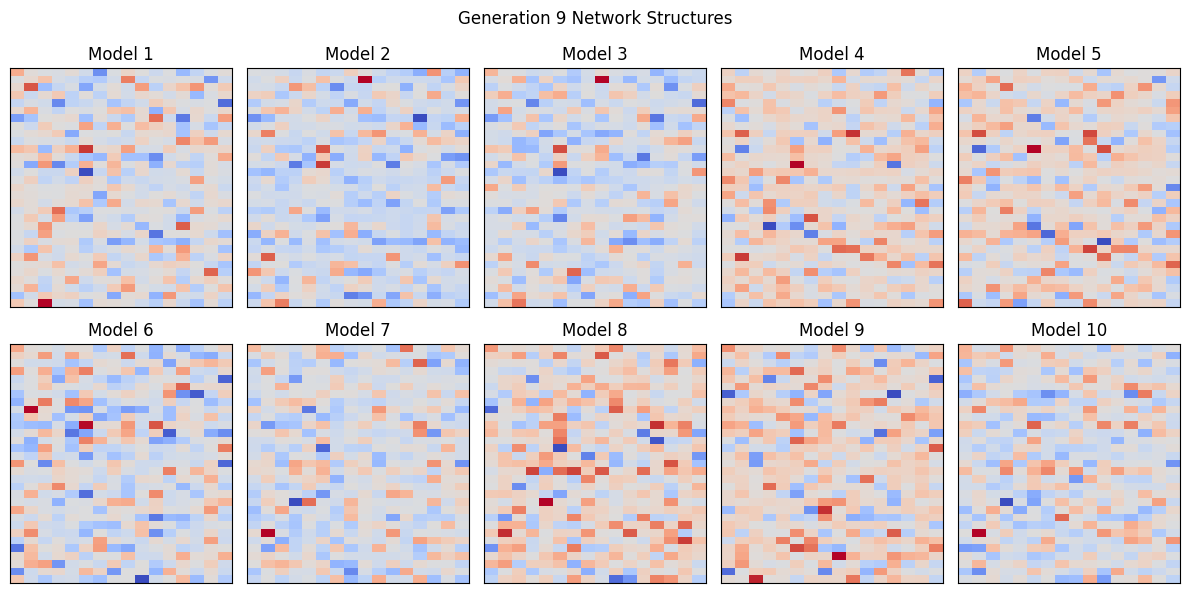

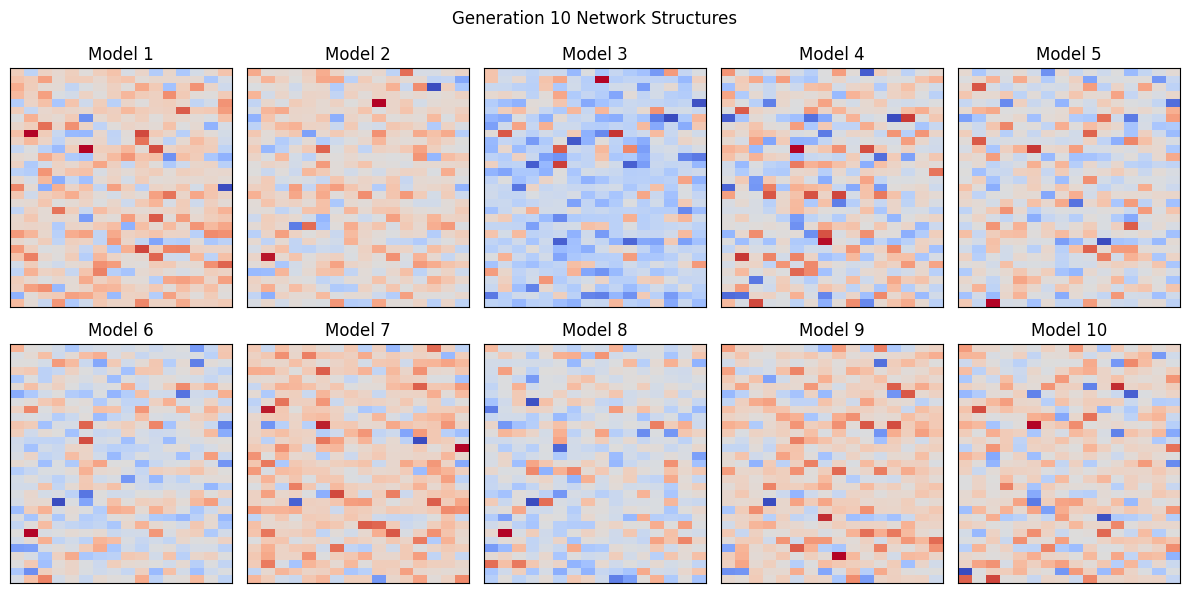

In [ ]:
# Visualize the network structure at different calendar times
for i, gen in enumerate(sane.history):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Generation {i+1} Network Structures")
    for j, weights in enumerate(gen):
        model = Sequential()
        model.add(Dense(16, input_shape=input_shape, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(output_shape, activation='sigmoid'))
        model.set_weights(weights)

        ax = plt.subplot(2, 5, j+1)
        ax.set_title(f"Model {j+1}")
        ax.set_xticks([])
        ax.set_yticks([])

        # Visualize the weights of the first hidden layer
        plt.imshow(model.get_weights()[0], cmap='coolwarm', aspect='auto')

    plt.tight_layout()
    plt.show()


It is used to test the best model obtained from the SANE algorithm and to plot the convergence of the accuracy during training.

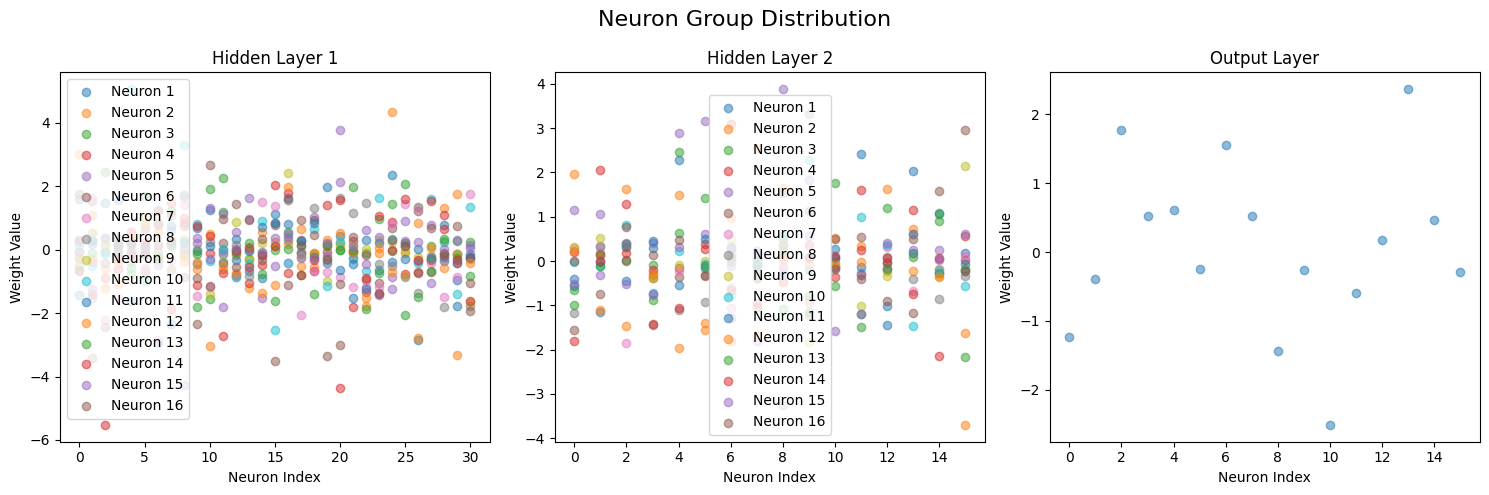

In [ ]:
# Mapping the distribution of neuronal clusters
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Neuron Group Distribution', fontsize=16)

# Get the weights of the best model
weights = best_model.get_weights()

# Statistical distribution of the weights of the first hidden layer neurons
hidden_layer1_weights = weights[0]
for i in range(hidden_layer1_weights.shape[1]):
    axes[0].scatter(range(hidden_layer1_weights.shape[0]), hidden_layer1_weights[:, i], alpha=0.5, label=f'Neuron {i+1}')

axes[0].set_title('Hidden Layer 1')
axes[0].set_xlabel('Neuron Index')
axes[0].set_ylabel('Weight Value')
axes[0].legend()

# Statistical weight distribution of the second hidden layer neurons
hidden_layer2_weights = weights[2]
for i in range(hidden_layer2_weights.shape[1]):
    axes[1].scatter(range(hidden_layer2_weights.shape[0]), hidden_layer2_weights[:, i], alpha=0.5, label=f'Neuron {i+1}')

axes[1].set_title('Hidden Layer 2')
axes[1].set_xlabel('Neuron Index')
axes[1].set_ylabel('Weight Value')
axes[1].legend()

# Weight distribution of neurons in the statistical output layer
output_layer_weights = weights[4]
axes[2].scatter(range(output_layer_weights.shape[0]), output_layer_weights, alpha=0.5)
axes[2].set_title('Output Layer')
axes[2].set_xlabel('Neuron Index')
axes[2].set_ylabel('Weight Value')

plt.tight_layout()
plt.show()
